**IMPORT CÁC THƯ VIỆN CẦN DÙNG**

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from datetime import datetime
from keras.layers import Dense, LSTM, Dropout, Activation, GRU
from pandas import DataFrame
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from bokeh.plotting import figure, show, output_file
from scipy import signal
import matplotlib.gridspec as gridspec
from itertools import product
import matplotlib as mpl
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**THU THẬP DỮ LIỆU**

In [ ]:
#Đường dẫn đến API
api_links = 'https://web-api.coinmarketcap.com/v1/cryptocurrency/ohlcv/historical?id=1&convert=USD&time_start=1262217600&time_end=1620604800'

response = requests.get(api_links)
data = response.json()
open = []
high = []
low = []
close = []
volume = []
market_cap = []
timestamp = []
time_high = []
time_low = []
for quote in data['data']['quotes']:
    time_high.append(str(quote['time_high']).split('T')[1].split('.')[0])
    time_low.append(str(quote['time_low']).split('T')[1].split('.')[0])
    quote = quote['quote']['USD']
    open.append(float(quote['open']))
    high.append(float(quote['high']))
    low.append(float(quote['low']))
    close.append(float(quote['close']))
    volume.append(float(quote['volume']))
    market_cap.append(float(quote['market_cap']))
    timestamp.append(str(quote['timestamp']).split('T')[0])


df_Bitcoin = pd.DataFrame()
df_Bitcoin['open'] = open
df_Bitcoin['high'] = high
df_Bitcoin['low'] = low
df_Bitcoin['close'] = close
df_Bitcoin['volume'] = volume
df_Bitcoin['market_cap'] = market_cap
df_Bitcoin['time_high'] = time_high
df_Bitcoin['time_low'] = time_low
df_Bitcoin['timestamp'] = timestamp

**CÁC THÔNG TIN VỀ DỮ LIỆU**

In [ ]:
df_Bitcoin.head()

open        high         low  ...  time_high  time_low   timestamp
0  134.444000  147.488007  134.000000  ...   13:15:01  05:20:01  2013-04-29
1  144.000000  146.929993  134.050003  ...   08:25:02  18:55:01  2013-04-30
2  139.000000  139.889999  107.720001  ...   00:15:01  19:55:01  2013-05-01
3  116.379997  125.599998   92.281898  ...   14:25:01  14:30:02  2013-05-02
4  106.250000  108.127998   79.099998  ...   05:30:02  03:05:01  2013-05-03

[5 rows x 9 columns]

In [ ]:
df_Bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934 entries, 0 to 2933
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        2934 non-null   float64
 1   high        2934 non-null   float64
 2   low         2934 non-null   float64
 3   close       2934 non-null   float64
 4   volume      2934 non-null   float64
 5   market_cap  2934 non-null   float64
 6   time_high   2934 non-null   object 
 7   time_low    2934 non-null   object 
 8   timestamp   2934 non-null   object 
dtypes: float64(6), object(3)
memory usage: 206.4+ KB


**TRỰC QUAN HÓA DỮ LIỆU**

In [ ]:
df_Bitcoin["timestamp"] = pd.to_datetime(df_Bitcoin["timestamp"])

In [ ]:
start = datetime(2013, 4, 29)
end = datetime(2021, 5, 10)
weekly_range = df_Bitcoin.groupby([pd.Grouper(key="timestamp", freq="W-MON")]).first().reset_index()

In [ ]:
weekly_range

timestamp          open          high  ...    market_cap  time_high  time_low
0   2013-04-29    134.444000    147.488007  ...  1.603769e+09   13:15:01  05:20:01
1   2013-05-06    144.000000    146.929993  ...  1.542813e+09   08:25:02  18:55:01
2   2013-05-13    112.250000    113.444000  ...  1.240594e+09   14:40:01  14:35:02
3   2013-05-20    117.980003    119.800003  ...  1.243874e+09   13:00:02  23:15:01
4   2013-05-27    122.019997    123.000000  ...  1.374013e+09   05:10:01  10:00:01
..         ...           ...           ...  ...           ...        ...       ...
415 2021-04-12  59171.932022  59479.578552  ...  1.086769e+12   01:02:03  14:32:03
416 2021-04-19  59890.017790  63742.283337  ...  1.186364e+12   16:04:03  00:03:03
417 2021-04-26  55681.792511  57062.150247  ...  1.055324e+12   22:02:03  07:38:03
418 2021-05-03  54030.303718  55416.964058  ...  1.028733e+12   21:50:03  04:19:03
419 2021-05-10  57214.178761  57214.178761  ...  9.973241e+11   00:00:04  23:56:03

[420 rows x 9 columns]

In [ ]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [ ]:
from IPython.display import HTML

trace1 = go.Scatter(
    x = weekly_range['timestamp'],
    y = weekly_range['open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_range['timestamp'],
    y = weekly_range['close'].astype(float),
    mode = 'lines',
    name = 'Close'
)

data = [trace1, trace2]
layout = dict(
    title = dict(
        text = "Historical Bitcoin prices (29/4/2013 - 10/5/2021) with the Slider",
        x = 0.5,
        y = 0.9),
    xaxis = dict(
        rangeselector = dict(
            buttons = list([
              dict(count=1,
                   label='1m',
                   step='month',
                   stepmode='backward'),
              dict(count=6,
                   label='6m',
                   step='month',
                   stepmode='backward'),
              dict(count=12,
                   label='1y',
                   step='month',
                   stepmode='backward'),
              dict(count=36,
                   label='3y',
                   step='month',
                   stepmode='backward'),
              dict(
                  step='all'
              )
            ]),
        ),
        rangeslider = dict(
            visible = True,
        ),
        type='date'
    )
)

fig = go.Figure(data=data, layout=layout)
HTML(fig.to_html())

In [ ]:
df_Bitcoin

open          high           low  ...  time_high  time_low  timestamp
0       134.444000    147.488007    134.000000  ...   13:15:01  05:20:01 2013-04-29
1       144.000000    146.929993    134.050003  ...   08:25:02  18:55:01 2013-04-30
2       139.000000    139.889999    107.720001  ...   00:15:01  19:55:01 2013-05-01
3       116.379997    125.599998     92.281898  ...   14:25:01  14:30:02 2013-05-02
4       106.250000    108.127998     79.099998  ...   05:30:02  03:05:01 2013-05-03
...            ...           ...           ...  ...        ...       ...        ...
2929  57441.307084  58363.314618  55382.506104  ...   10:24:03  19:19:03 2021-05-06
2930  56413.953551  58606.633967  55321.846710  ...   17:07:03  04:39:03 2021-05-07
2931  57352.765953  59464.612493  56975.210653  ...   20:30:03  00:13:03 2021-05-08
2932  58877.388698  59210.881789  56482.003545  ...   01:48:03  13:00:03 2021-05-09
2933  58250.872531  59519.354426  54071.455379  ...   04:07:03  20:06:03 2021-05-10

[2934 rows x 9 columns]

In [ ]:
visualize_df = df_Bitcoin.set_index("timestamp")

In [ ]:
visualize_df = visualize_df.drop(visualize_df.columns[[4, 5]], axis=1)

In [ ]:
visualize_df

open          high  ...  time_high  time_low
timestamp                               ...                     
2013-04-29    134.444000    147.488007  ...   13:15:01  05:20:01
2013-04-30    144.000000    146.929993  ...   08:25:02  18:55:01
2013-05-01    139.000000    139.889999  ...   00:15:01  19:55:01
2013-05-02    116.379997    125.599998  ...   14:25:01  14:30:02
2013-05-03    106.250000    108.127998  ...   05:30:02  03:05:01
...                  ...           ...  ...        ...       ...
2021-05-06  57441.307084  58363.314618  ...   10:24:03  19:19:03
2021-05-07  56413.953551  58606.633967  ...   17:07:03  04:39:03
2021-05-08  57352.765953  59464.612493  ...   20:30:03  00:13:03
2021-05-09  58877.388698  59210.881789  ...   01:48:03  13:00:03
2021-05-10  58250.872531  59519.354426  ...   04:07:03  20:06:03

[2934 rows x 6 columns]

In [ ]:
visualize_df.describe()

open          high           low         close
count   2934.000000   2934.000000   2934.000000   2934.000000
mean    6089.669501   6260.577635   5911.663716   6108.395460
std    10476.250029  10797.301113  10130.134084  10515.515725
min       68.504997     74.561096     65.526001     68.431000
25%      424.334740    432.698997    419.650505    424.321510
50%     1515.794983   1587.760010   1510.515015   1546.559998
75%     8230.634196   8386.196820   8024.859556   8230.388661
max    63523.754869  64863.098908  62208.964366  63503.457930

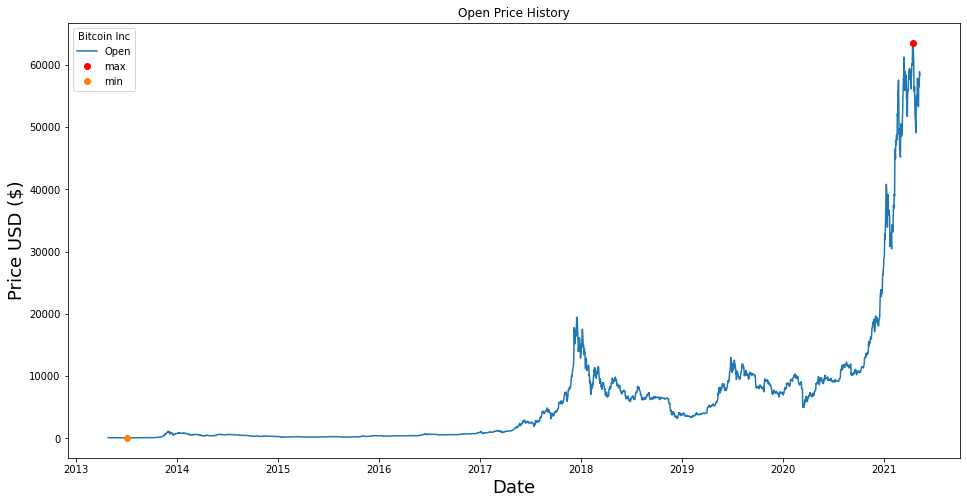

In [ ]:
#Visualize the open price history
plt.figure(figsize=(16, 8))
plt.title('Open Price History')
plt.plot(visualize_df['open'], label='Open')
plt.plot(visualize_df['open'].idxmax(), visualize_df['open'].max(), 'ro', label='max', )
plt.plot(visualize_df['open'].idxmin(), visualize_df['open'].min(), 'o', label='min')
plt.legend(title = 'Bitcoin Inc', loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.show()

In [ ]:
print(visualize_df['open'].idxmin())
print(visualize_df['open'].idxmax())

2013-07-06 00:00:00
2021-04-14 00:00:00


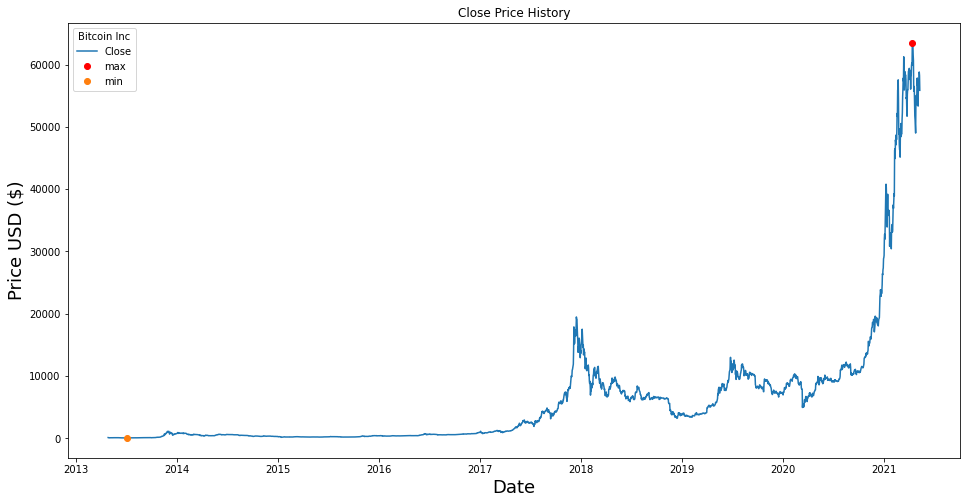

In [ ]:
#Visualize the close price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(visualize_df['close'], label='Close')
plt.plot(visualize_df['close'].idxmax(), visualize_df['close'].max(), 'ro', label='max', )
plt.plot(visualize_df['close'].idxmin(), visualize_df['close'].min(), 'o', label='min')
plt.legend(title = 'Bitcoin Inc', loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.show()

In [ ]:
print(visualize_df['close'].idxmin())
print(visualize_df['close'].idxmax())

2013-07-05 00:00:00
2021-04-13 00:00:00


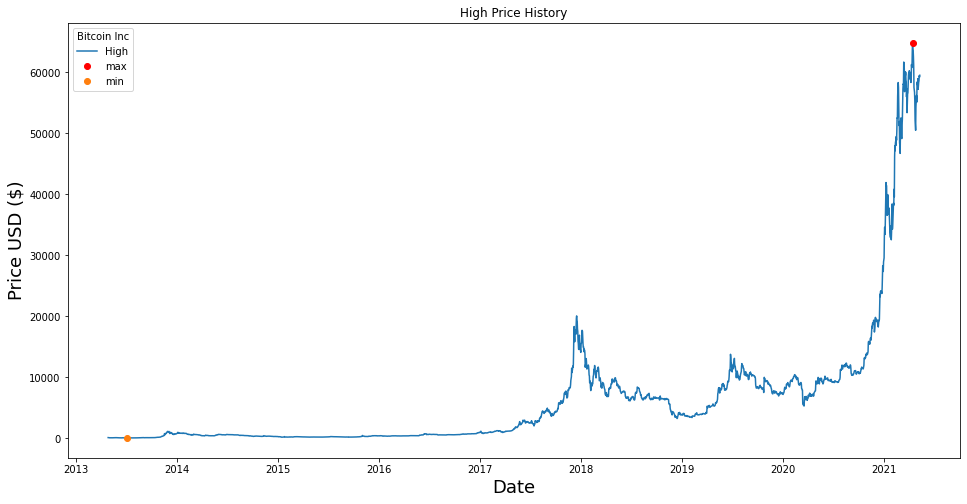

In [ ]:
#Visualize the high price history
plt.figure(figsize=(16, 8))
plt.title('High Price History')
plt.plot(visualize_df['high'], label='High')
plt.plot(visualize_df['high'].idxmax(), visualize_df['high'].max(), 'ro', label='max', )
plt.plot(visualize_df['high'].idxmin(), visualize_df['high'].min(), 'o', label='min')
plt.legend(title = 'Bitcoin Inc', loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.show()

In [ ]:
print(visualize_df['high'].idxmin())
print(visualize_df['high'].idxmax())

2013-07-07 00:00:00
2021-04-14 00:00:00


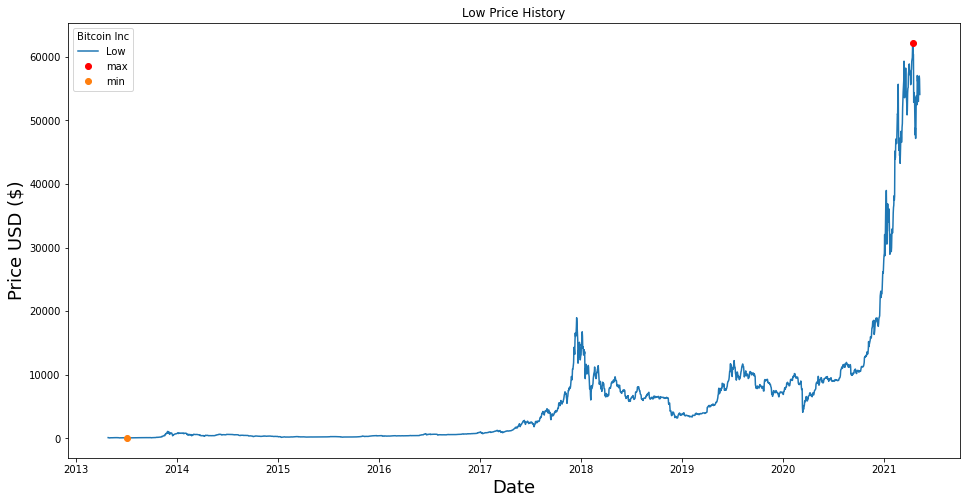

In [ ]:
#Visualize the low price history
plt.figure(figsize=(16, 8))
plt.title('Low Price History')
plt.plot(visualize_df['low'], label='Low')
plt.plot(visualize_df['low'].idxmax(), visualize_df['low'].max(), 'ro', label='max', )
plt.plot(visualize_df['low'].idxmin(), visualize_df['low'].min(), 'o', label='min')
plt.legend(title = 'Bitcoin Inc', loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.show()

In [ ]:
print(visualize_df['low'].idxmin())
print(visualize_df['low'].idxmax())

2013-07-05 00:00:00
2021-04-15 00:00:00


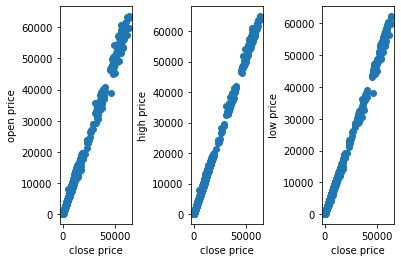

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
ax1.scatter(visualize_df.close, visualize_df.open)
ax1.set_xlabel('close price')
ax1.set_ylabel('open price')

ax2.scatter(visualize_df.close, visualize_df.high)
ax2.set_xlabel('close price')
ax2.set_ylabel('high price')

ax3.scatter(visualize_df.close, visualize_df.low)
ax3.set_xlabel('close price')
ax3.set_ylabel('low price')
plt.subplots_adjust(wspace=0.8)

In [ ]:
visualize_df['time_high'] = visualize_df['time_high'].apply(lambda x: (datetime.strptime(str(x), '%H:%M:%S')).time())

In [ ]:
visualize_df['time_high'][0]

datetime.time(13, 15, 1)

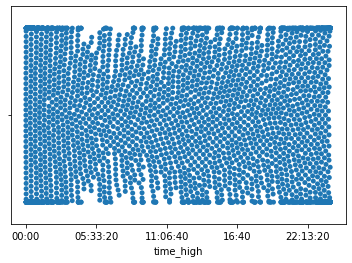

In [ ]:
pd.plotting.register_matplotlib_converters()
sns.swarmplot(visualize_df['time_high'])

In [ ]:
visualize_df['time_low'] = visualize_df['time_low'].apply(lambda x: (datetime.strptime(str(x), '%H:%M:%S')).time())

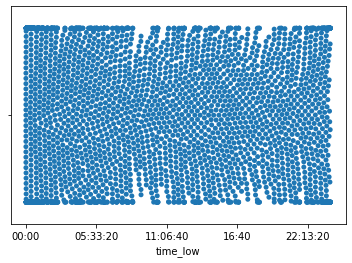

In [ ]:
sns.swarmplot(visualize_df['time_low'])

### SMA

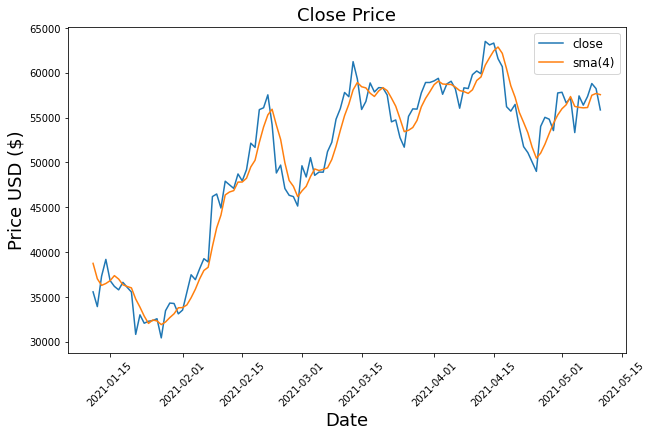

In [ ]:
bitcoin_sma = visualize_df.rolling(window=4).mean()
plt.figure(figsize=(10, 6))
plt.plot(visualize_df.tail(120).close, label='close')
plt.plot(bitcoin_sma.tail(120).close, label='sma(4)')
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.legend(fontsize=12)
plt.title('Close Price', fontsize=18)
plt.show()

### Ewm (đường trung bình trượt cấp số nhân)

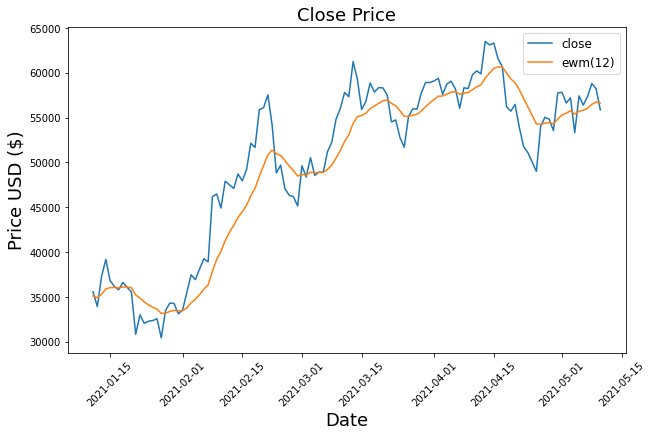

In [ ]:
bitcoin_smaMul = visualize_df.ewm(span=12, adjust=False).mean()
plt.figure(figsize=(10, 6))
plt.plot(visualize_df.tail(120).close, label='close')
plt.plot(bitcoin_smaMul.tail(120).close, label='ewm(12)')
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.legend(fontsize=12)
plt.title('Close Price', fontsize=18)
plt.show()

### Biểu đồ nến (candle stick)

In [ ]:
visualize_df['middle']=(visualize_df['open'] + visualize_df['close'])/2
visualize_df['height']=abs(visualize_df['close']-visualize_df['open'])

In [ ]:
visualize_df

open          high  ...        middle       height
timestamp                               ...                           
2013-04-29    134.444000    147.488007  ...    139.491997    10.095993
2013-04-30    144.000000    146.929993  ...    141.500000     5.000000
2013-05-01    139.000000    139.889999  ...    127.994999    22.010002
2013-05-02    116.379997    125.599998  ...    110.794998    11.169998
2013-05-03    106.250000    108.127998  ...    102.000000     8.500000
...                  ...           ...  ...           ...          ...
2021-05-06  57441.307084  58363.314618  ...  56918.910624  1044.792920
2021-05-07  56413.953551  58606.633967  ...  56885.177714   942.448326
2021-05-08  57352.765953  59464.612493  ...  58078.270881  1451.009856
2021-05-09  58877.388698  59210.881789  ...  58554.852420   645.072556
2021-05-10  58250.872531  59519.354426  ...  57055.335038  2391.074986

[2934 rows x 8 columns]

In [ ]:
def inc_dec(c, o):
    if c > o:
        value='Increase'
    elif c < o:
        value='Decrease'
    else:
        value='Equal'
    return value

In [ ]:
visualize_df['status'] = [inc_dec(c, o) for c, o in zip(visualize_df.close, visualize_df.open)]

In [ ]:
temp = visualize_df.tail(700)
SMA50 = visualize_df['close'].rolling(window = 50).mean()
SMA200 = visualize_df['close'].rolling(window = 200).mean()

In [ ]:
SMA = pd.DataFrame({'SMA50': SMA50, 'SMA200': SMA200}, index=SMA50.index)

In [ ]:
p = figure(x_axis_type='datetime', width=1500, height=600)
p.title.text='Candelstick Chart'
hours_12=12*60*60*1000
p.segment(temp.index, temp.high, temp.index, temp.low, color='black')
p.rect(temp.index[temp.status=='Increase'], temp.middle[temp.status=='Increase'],
      hours_12, temp.height[temp.status=='Increase'], fill_color='#42f55a', line_color='black')
p.rect(temp.index[temp.status=='Decrease'], temp.middle[temp.status=='Decrease'],
      hours_12, temp.height[temp.status=='Decrease'], fill_color='#f54242', line_color='black')
p.line(x='timestamp', y='SMA50', source=SMA.tail(700), line_color='red', name='SMA50')
p.line(x='timestamp', y='SMA200', source=SMA.tail(700), line_color='blue', name='SMA200')
show(p)

### Loại bỏ yếu tố xu thế

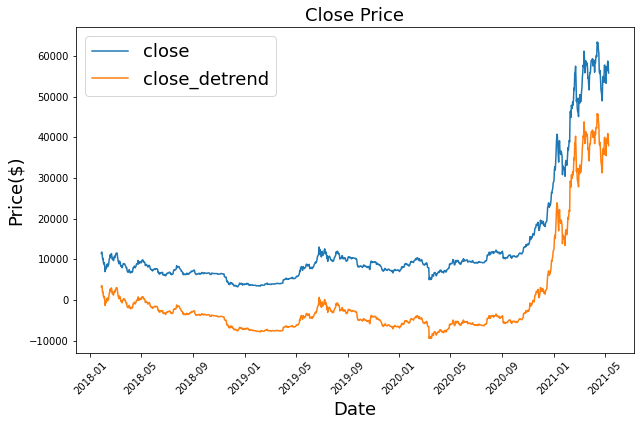

In [ ]:
x_detrend = signal.detrend(visualize_df['close'])
bitcoin_detrend = pd.DataFrame({"close_detrend": x_detrend}, index=visualize_df.index)

plt.figure(figsize=(10, 6))
plt.plot(visualize_df["close"].tail(1200), label="close")
plt.plot(bitcoin_detrend.tail(1200), label="close_detrend")
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price($)", fontsize=18)
plt.legend(fontsize=18)
plt.title("Close Price", fontsize=18)
plt.show()

### phát hiện yếu tố chu kì và mùa vụ

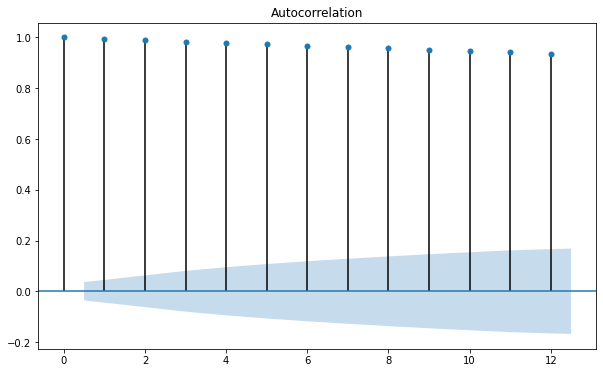

In [ ]:
mpl.rc("figure", figsize=(10, 6))
plot_acf(visualize_df['close'], lags = 12)
plt.show()

### phân rã mùa vụ



*   Phân rã cộng tính



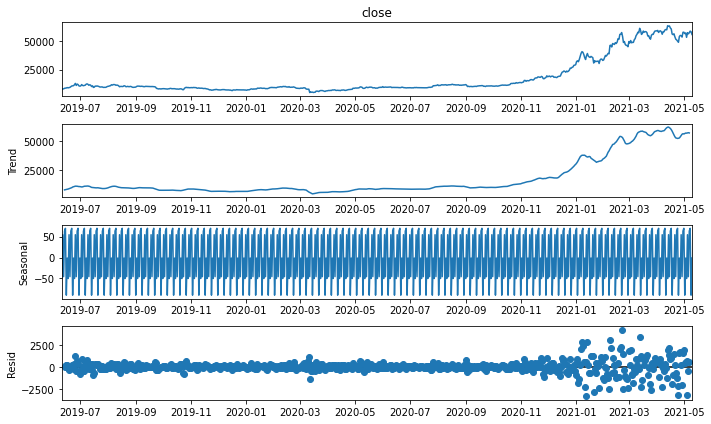

In [ ]:
result = seasonal_decompose(visualize_df.tail(700).close, model='additive')
result.plot()
plt.show()



*   Phân rã nhân tính



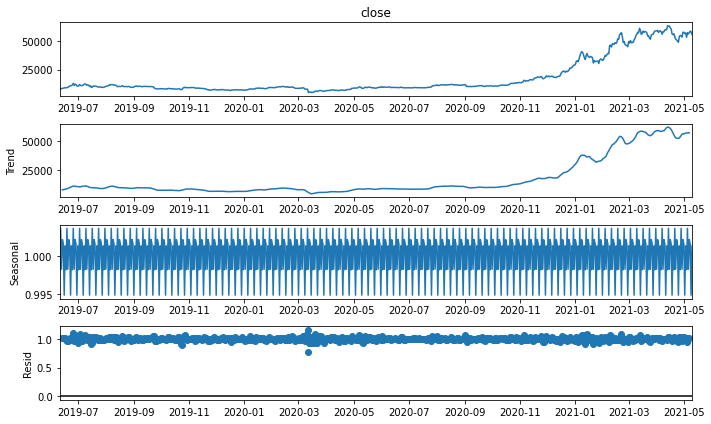

In [ ]:
result = seasonal_decompose(visualize_df.tail(700).close, model='multiplicative')
result.plot()
plt.show()

>  **LỰA CHỌN ĐẶC TRƯNG CẦN CHO VIỆC DỰ ĐOÁN, VÀ CHIA TẬP DỮ LIỆU THÀNH PHẦN TRAIN VÀ TEST**










In [ ]:
data = df_Bitcoin.set_index("timestamp")
data = data[["close"]]

In [ ]:
data

close
timestamp               
2013-04-29    144.539993
2013-04-30    139.000000
2013-05-01    116.989998
2013-05-02    105.209999
2013-05-03     97.750000
...                  ...
2021-05-06  56396.514164
2021-05-07  57356.401877
2021-05-08  58803.775809
2021-05-09  58232.316142
2021-05-10  55859.797545

[2934 rows x 1 columns]

In [ ]:
iter_split = int(len(df_Bitcoin)*0.8)
train_data = data[:iter_split].copy()
test_data = data[iter_split:].copy()

In [ ]:
train_data

close
timestamp              
2013-04-29   144.539993
2013-04-30   139.000000
2013-05-01   116.989998
2013-05-02   105.209999
2013-05-03    97.750000
...                 ...
2019-09-27  8251.845557
2019-09-28  8245.915155
2019-09-29  8104.185676
2019-09-30  8293.867741
2019-10-01  8343.276681

[2347 rows x 1 columns]

In [ ]:
test_data

close
timestamp               
2019-10-02   8393.041645
2019-10-03   8259.991979
2019-10-04   8205.939241
2019-10-05   8151.500529
2019-10-06   7988.155959
...                  ...
2021-05-06  56396.514164
2021-05-07  57356.401877
2021-05-08  58803.775809
2021-05-09  58232.316142
2021-05-10  55859.797545

[587 rows x 1 columns]

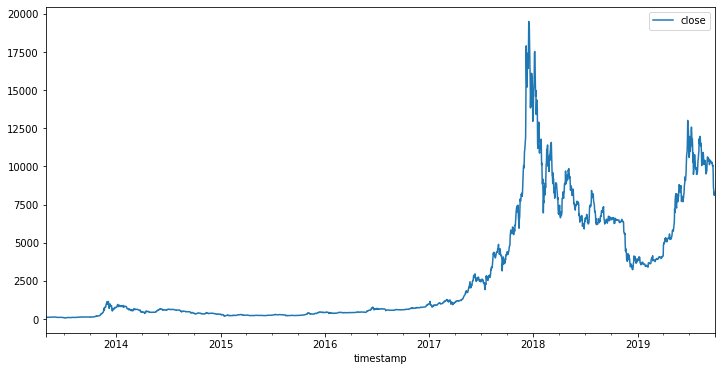

In [ ]:
train_data.plot(figsize=(12,6))

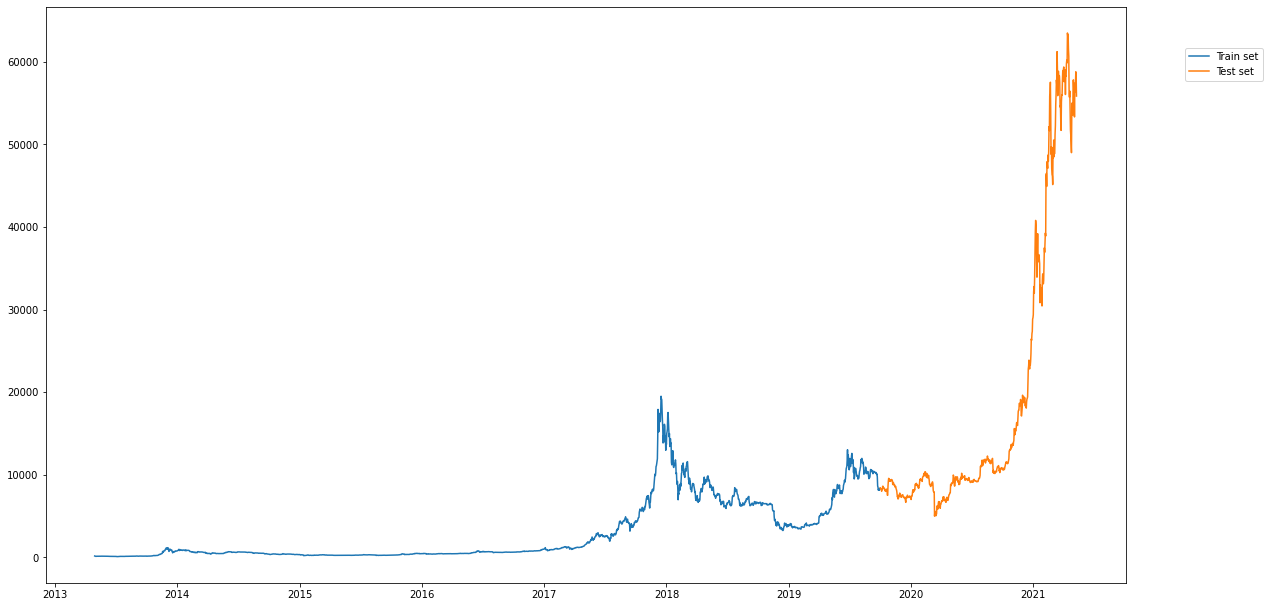

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])
ax.plot(train_data.index, train_data.values, label="Train set")
ax.plot(test_data.index, test_data.values, label="Test set")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.9))



> **XÂY DỰNG MÔ HÌNH LSTM**



In [ ]:
train_set = train_data.values
test_set = test_data.values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [ ]:
train_set = sc.fit_transform(train_set)
X_train = train_set[:len(train_set)-1]
y_train = train_set[1:len(train_set)]
X_train = X_train.reshape((len(X_train), 1, 1))

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2) #số verbose để xem output trong quá trình huấn luyện

Epoch 1/100
47/47 - 2s - loss: 0.0337
Epoch 2/100
47/47 - 0s - loss: 0.0162
Epoch 3/100
47/47 - 0s - loss: 0.0052
Epoch 4/100
47/47 - 0s - loss: 6.9262e-04
Epoch 5/100
47/47 - 0s - loss: 3.4993e-04
Epoch 6/100
47/47 - 0s - loss: 3.9780e-04
Epoch 7/100
47/47 - 0s - loss: 3.7275e-04
Epoch 8/100
47/47 - 0s - loss: 3.8693e-04
Epoch 9/100
47/47 - 0s - loss: 3.2426e-04
Epoch 10/100
47/47 - 0s - loss: 3.9190e-04
Epoch 11/100
47/47 - 0s - loss: 3.5160e-04
Epoch 12/100
47/47 - 0s - loss: 3.3766e-04
Epoch 13/100
47/47 - 0s - loss: 3.3865e-04
Epoch 14/100
47/47 - 0s - loss: 3.2988e-04
Epoch 15/100
47/47 - 0s - loss: 3.4789e-04
Epoch 16/100
47/47 - 0s - loss: 2.8333e-04
Epoch 17/100
47/47 - 0s - loss: 3.2471e-04
Epoch 18/100
47/47 - 0s - loss: 3.2770e-04
Epoch 19/100
47/47 - 0s - loss: 3.2866e-04
Epoch 20/100
47/47 - 0s - loss: 3.3959e-04
Epoch 21/100
47/47 - 0s - loss: 3.4109e-04
Epoch 22/100
47/47 - 0s - loss: 3.2105e-04
Epoch 23/100
47/47 - 0s - loss: 3.2617e-04
Epoch 24/100
47/47 - 0s - loss: 

In [ ]:
test_set = sc.transform(test_set)
X_test = test_set

In [ ]:
X_test[:5]

array([[0.42846383],
       [0.42161583],
       [0.41883376],
       [0.41603182],
       [0.40762455]])

In [ ]:
X_test = X_test.reshape((len(X_test), 1, 1))

In [ ]:
predicted_price = model.predict(X_test)

In [ ]:
predicted_price = sc.inverse_transform(predicted_price)

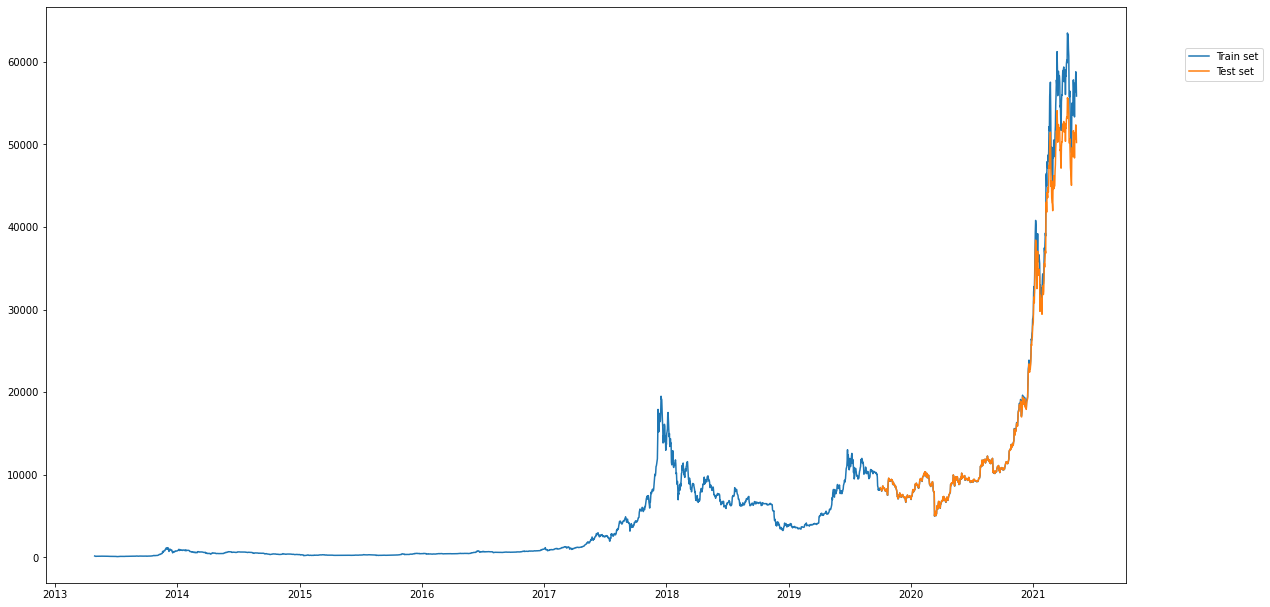

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])
ax.plot(data.index, data.values, label="Train set")
ax.plot(test_data.index, predicted_price, label="Test set")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.9))



> **XÂY DỰNG MÔ HÌNH GRU**




In [ ]:
model = Sequential()
model.add(GRU(128, input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2) #số verbose để xem output trong quá trình huấn luyện

Epoch 1/100
47/47 - 2s - loss: 0.0214
Epoch 2/100
47/47 - 0s - loss: 0.0037
Epoch 3/100
47/47 - 0s - loss: 3.9452e-04
Epoch 4/100
47/47 - 0s - loss: 3.8449e-04
Epoch 5/100
47/47 - 0s - loss: 3.6991e-04
Epoch 6/100
47/47 - 0s - loss: 3.7461e-04
Epoch 7/100
47/47 - 0s - loss: 3.5268e-04
Epoch 8/100
47/47 - 0s - loss: 3.9325e-04
Epoch 9/100
47/47 - 0s - loss: 3.4511e-04
Epoch 10/100
47/47 - 0s - loss: 3.8645e-04
Epoch 11/100
47/47 - 0s - loss: 3.5270e-04
Epoch 12/100
47/47 - 0s - loss: 3.4805e-04
Epoch 13/100
47/47 - 0s - loss: 3.5247e-04
Epoch 14/100
47/47 - 0s - loss: 3.6797e-04
Epoch 15/100
47/47 - 0s - loss: 3.3220e-04
Epoch 16/100
47/47 - 0s - loss: 3.2694e-04
Epoch 17/100
47/47 - 0s - loss: 3.6633e-04
Epoch 18/100
47/47 - 0s - loss: 3.4590e-04
Epoch 19/100
47/47 - 0s - loss: 3.6790e-04
Epoch 20/100
47/47 - 0s - loss: 3.3099e-04
Epoch 21/100
47/47 - 0s - loss: 3.2882e-04
Epoch 22/100
47/47 - 0s - loss: 3.5609e-04
Epoch 23/100
47/47 - 0s - loss: 3.6789e-04
Epoch 24/100
47/47 - 0s - lo

In [ ]:
predicted_price_GRU = model.predict(X_test)
predicted_price_GRU = sc.inverse_transform(predicted_price_GRU)

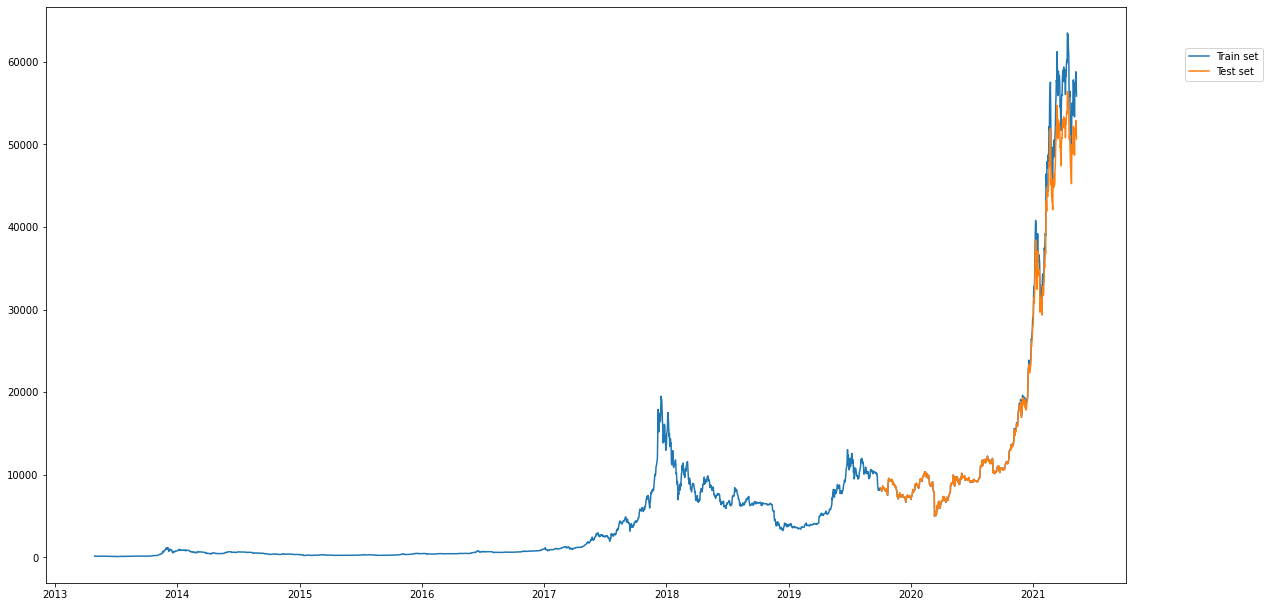

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])
ax.plot(data.index, data.values, label="Train set")
ax.plot(test_data.index, predicted_price_GRU, label="Test set")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.9))



> **XÂY DỰNG MÔ HÌNH ARIMA**



In [ ]:
df_Bitcoin.head()

open        high         low  ...  time_high  time_low  timestamp
0  134.444000  147.488007  134.000000  ...   13:15:01  05:20:01 2013-04-29
1  144.000000  146.929993  134.050003  ...   08:25:02  18:55:01 2013-04-30
2  139.000000  139.889999  107.720001  ...   00:15:01  19:55:01 2013-05-01
3  116.379997  125.599998   92.281898  ...   14:25:01  14:30:02 2013-05-02
4  106.250000  108.127998   79.099998  ...   05:30:02  03:05:01 2013-05-03

[5 rows x 9 columns]

In [ ]:
df_Bitcoin.isnull().sum()

open          0
high          0
low           0
close         0
volume        0
market_cap    0
time_high     0
time_low      0
timestamp     0
dtype: int64

In [ ]:
df_Bitcoin.dtypes

open                 float64
high                 float64
low                  float64
close                float64
volume               float64
market_cap           float64
time_high             object
time_low              object
timestamp     datetime64[ns]
dtype: object

Text(0, 0.5, 'Bitcoin Close Daily')

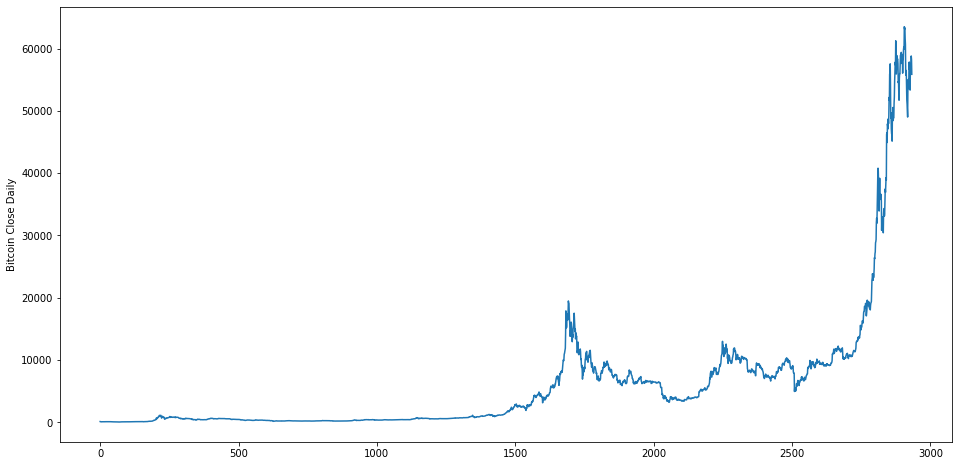

In [ ]:
df_Bitcoin['close'].plot(figsize = (16,8))
plt.ylabel("Bitcoin Close Daily")

In [ ]:
#Unix-time to 
df_Bitcoin.timestamp = pd.to_datetime(df_Bitcoin.timestamp)

# Resampling to daily frequency
df_Bitcoin.set_index('timestamp',inplace=True)
df_day = df_Bitcoin.resample('D').mean()

# Resampling to monthly frequency
df_month = df_Bitcoin.resample('M').mean()

# Resampling to annual frequency
df_year = df_Bitcoin.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df_Bitcoin.resample('Q-DEC').mean()

In [ ]:
df_month.head()

open        high  ...  volume    market_cap
timestamp                           ...                      
2013-04-30  139.222000  147.209000  ...     0.0  1.573291e+09
2013-05-31  120.292097  123.949096  ...     0.0  1.339718e+09
2013-06-30  108.856067  111.300543  ...     0.0  1.216792e+09
2013-07-31   90.311422   93.868936  ...     0.0  1.034233e+09
2013-08-31  113.041936  116.002226  ...     0.0  1.317466e+09

[5 rows x 6 columns]

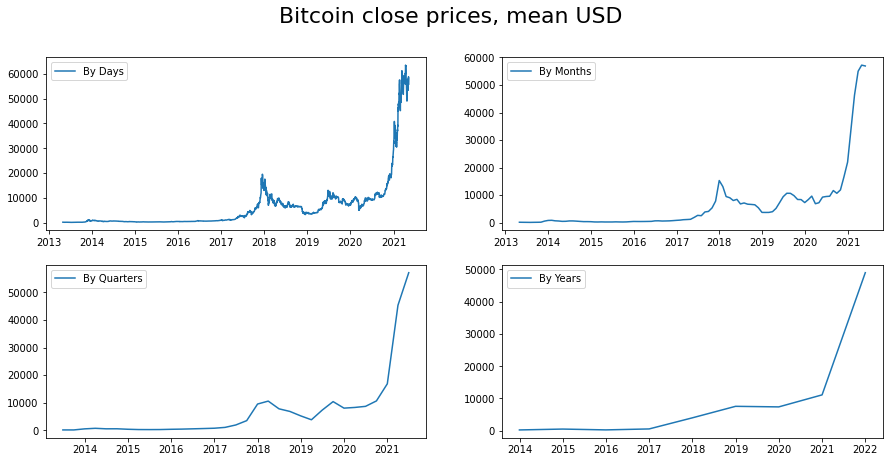

In [ ]:
# PLOTS the timestamped data, in various different forms - days, months, quaters, yearly
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin close prices, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_day.close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.close, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Bitcoin Close Mean Price for weeks')

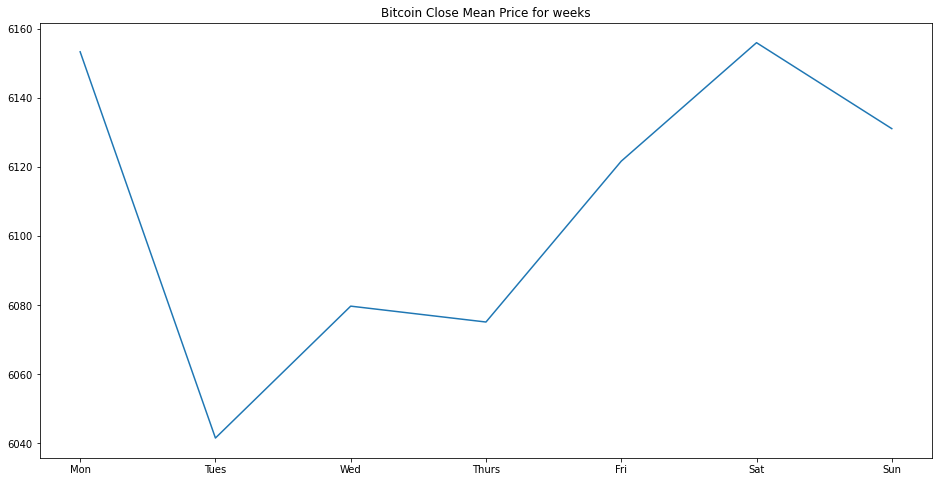

In [ ]:
by_weekday = df_Bitcoin.groupby(df_Bitcoin.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday['close'].plot(figsize =(16,8))
plt.title("Bitcoin Close Mean Price for weeks")

An ARIMA model is characterized by 3 terms p, d, q:
- p is the order of the AR term
- d is the number of differencing required to make the time series stationary
- q is the order of the MA term

## Stationarity

Subtract the previous value from the current value. Now if we just difference one, we might not get a stationary series so we might need to do that multiple times. And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model.

## Adf test

Dickey–Fuller test: p=0.999088


<Figure size 1152x576 with 0 Axes>

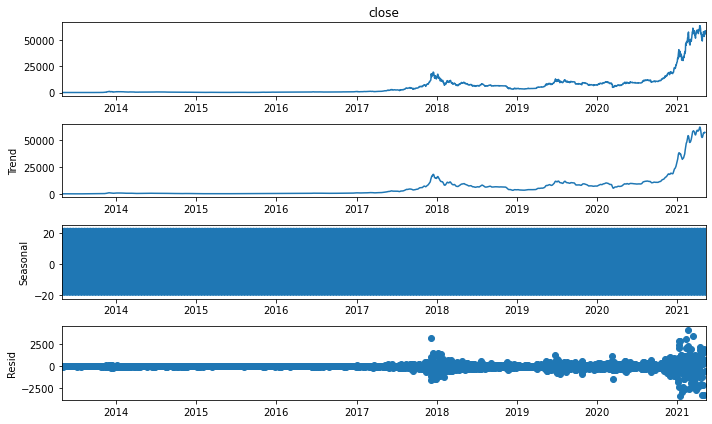

In [ ]:
# All the Timeseries algorithms works well with Stationary Dataset (add definitation)
# Also add definination of non-stationary dataset

# We are using Dicky-Fully Test to check whether a dataset is stationary of not 
# if val<0.05, then the dataset is stationary
# else, dataset set is stationary

# To make a dataset stationary we will perform various transforms and 
# to predict the final output we will be performing the inverse of those transforms

# Stationarity check for Original Dataset

plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(df_Bitcoin.close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_Bitcoin.close)[1])
plt.show()

In [ ]:
#Now we are performing Seasonal

#Seasonal differentiation
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(close):
    result=adfuller(close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [ ]:
data = df_Bitcoin[['close']]
data.describe()

close
count   2934.000000
mean    6108.395460
std    10515.515725
min       68.431000
25%      424.321510
50%     1546.559998
75%     8230.388661
max    63503.457930

In [ ]:
adfuller_test(data['close'])

ADF Test Statistic : 2.7108590072557335
p-value : 0.9990875150055181
#Lags Used : 28
Number of Observations Used : 2905
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
data['Close First Difference'] = data['close'] - data['close'].shift(1)
data['Seasonal First Difference'] = data['close'] - data['close'].shift(12)
data

close  Close First Difference  Seasonal First Difference
timestamp                                                                  
2013-04-29    144.539993                     NaN                        NaN
2013-04-30    139.000000               -5.539993                        NaN
2013-05-01    116.989998              -22.010002                        NaN
2013-05-02    105.209999              -11.779999                        NaN
2013-05-03     97.750000               -7.459999                        NaN
...                  ...                     ...                        ...
2021-05-06  56396.514164            -1027.491784                6345.645948
2021-05-07  57356.401877              959.887713                8352.148614
2021-05-08  58803.775809             1447.373932                4782.021021
2021-05-09  58232.316142             -571.459667                3199.198129
2021-05-10  55859.797545            -2372.518597                1035.092649

[2934 rows x 3 columns]

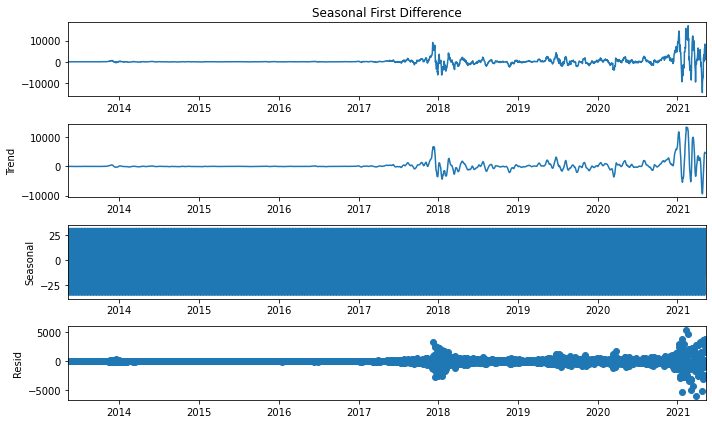

In [ ]:
# STL-decomposition
sm.tsa.seasonal_decompose(data['Seasonal First Difference'].dropna()).plot()   

plt.show()

In [ ]:
## Again test dickey fuller test
adfuller_test(data['Seasonal First Difference'].dropna())

ADF Test Statistic : -6.038335628614647
p-value : 1.3649153006459618e-07
#Lags Used : 27
Number of Observations Used : 2894
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


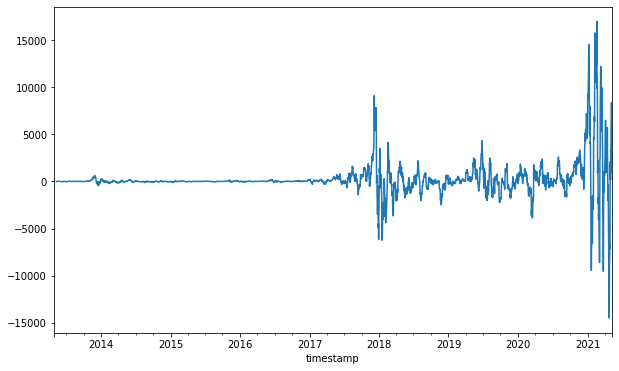

In [ ]:
data['Seasonal First Difference'].plot()

## Autocorrelation Funtion (ACF) and Partial Autocorrelation Function (PACF)

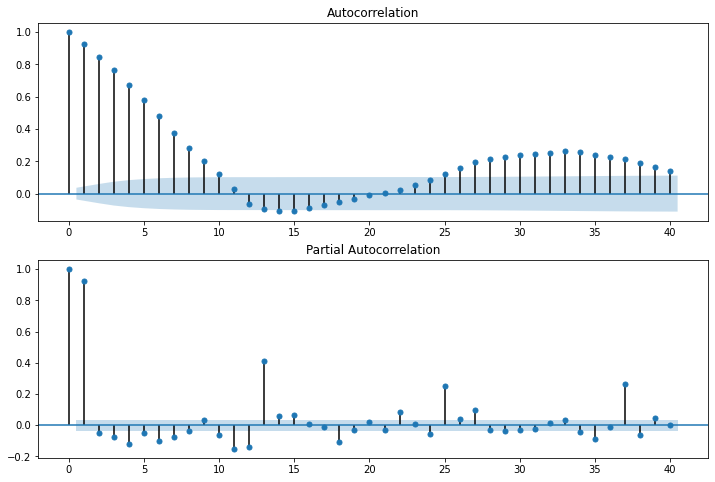

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima.utils import ndiffs
ndiffs(df_Bitcoin.close, test='adf')

1

### d = 1

In [ ]:
p = q = range(0,5)
d = range(1,2)
pdq = list(product(p,d,q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4)]

In [ ]:
for param in pdq:
    try:
        model_arima = ARIMA(data.close,order=param)
        model_fit = model_arima.fit()
        print(f'{param} : {model_fit.aic}')
    except:
        continue

(0, 1, 0) : 44871.62479518443
(0, 1, 1) : 44873.06506658855
(0, 1, 2) : 44871.91010847075
(0, 1, 3) : 44866.23679312109
(0, 1, 4) : 44866.89766815338
(1, 1, 0) : 44873.03030902743
(1, 1, 1) : 44874.6760297607
(1, 1, 2) : 44870.38177882103
(1, 1, 3) : 44866.71521193624
(1, 1, 4) : 44868.44384007098
(2, 1, 0) : 44872.37042801718
(2, 1, 1) : 44870.919619020904
(2, 1, 2) : 44807.75855115117
(2, 1, 3) : 44808.60593322838
(2, 1, 4) : 44809.14872478682
(3, 1, 0) : 44865.403196299085
(3, 1, 1) : 44865.91974382862
(3, 1, 2) : 44817.94960566447
(3, 1, 3) : 44811.62758835931
(3, 1, 4) : 44810.2523745688
(4, 1, 0) : 44865.759333889764
(4, 1, 1) : 44867.64369302772
(4, 1, 2) : 44809.38169231058
(4, 1, 3) : 44810.2273403173
(4, 1, 4) : 44783.406991249845


## Fitting the Arima Model 

In [ ]:
#Arima Model
model = ARIMA(data.close,order=(2,1,2))
result = model.fit(disp=0)

In [ ]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2933
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -22397.879
Method:                       css-mle   S.D. of innovations            501.448
Date:                Tue, 10 Aug 2021   AIC                          44807.759
Time:                        16:37:13   BIC                          44843.661
Sample:                    04-30-2013   HQIC                         44820.687
                         - 05-10-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            18.7892     10.077      1.865      0.062      -0.962      38.540
ar.L1.D.close     1.2997      0.024     54.161      0.000       1.253       1.347
ar.L2.D.close    -0.8755      0.022    -

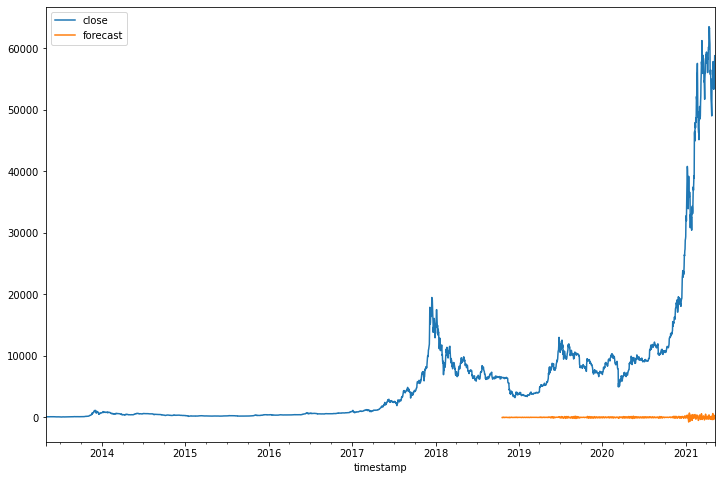

In [ ]:
data['forecast']=result.predict(start=2000,end=2932,dynamic=False)
data[['close','forecast']].plot(figsize=(12,8))

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.00080357, ..., 0.        , 0.        ,
         0.        ]]),
 array([-5426.68433088, -4182.24036093, -2937.79639098, -1693.35242102,
         -448.90845107,   795.53551888,  2039.97948884,  3284.42345879,
         4528.86742874,  5773.3113987 ,  7017.75536865]),
 <a list of 2933 Lists of Patches objects>)

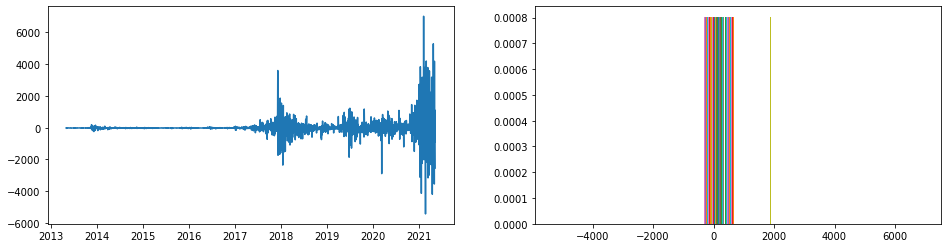

In [ ]:
#plot residual errors
residuals = pd.DataFrame(result.resid)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.plot(residuals)
ax2.hist(residuals,density= True)

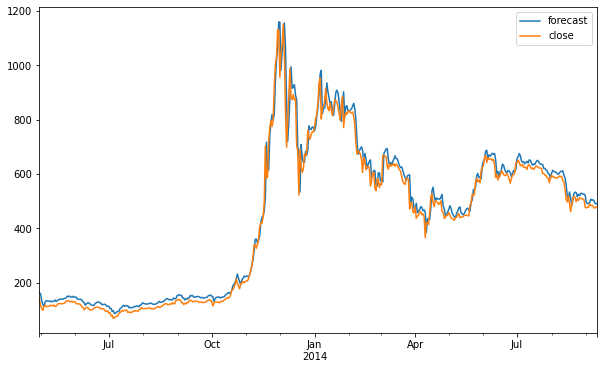

In [ ]:
#Actual and Fitted

result.plot_predict(start = 1,end = 500,dynamic = False);

## Train test split

In [ ]:
#Train,test model

n = int(len(data)*0.8)
train = data[:n]
test = data[n:]


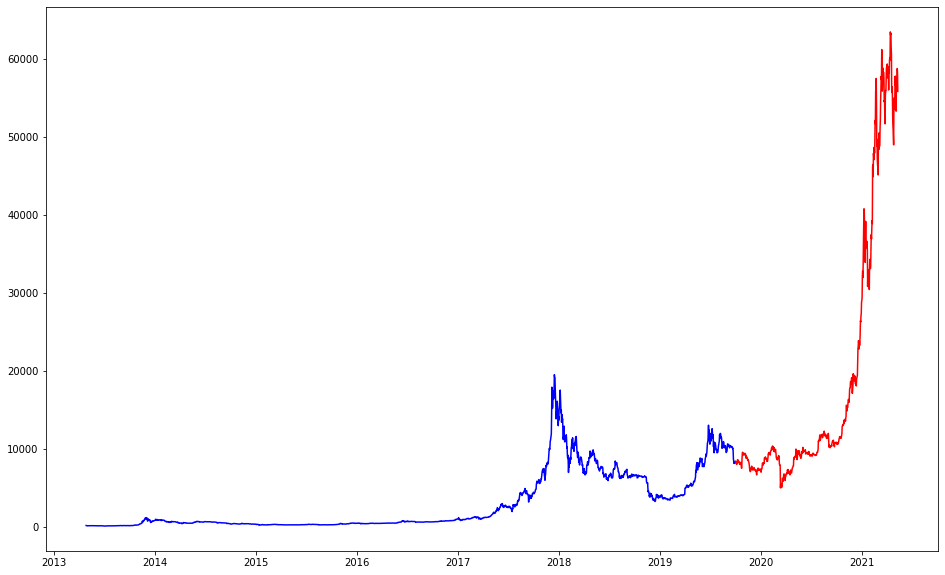

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train['close'], 'blue', label = 'Train')
plt.plot(test['close'], 'red', label = 'Test')
plt.show()


In [ ]:
# Arima Training
model = ARIMA(train['close'],order=(2,1,2))
result = model.fit(disp=0)


In [ ]:
print(result.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2346
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -16244.358
Method:                       css-mle   S.D. of innovations            245.971
Date:                Tue, 10 Aug 2021   AIC                          32500.717
Time:                        16:38:22   BIC                          32535.280
Sample:                    04-30-2013   HQIC                         32513.305
                         - 10-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.4834      5.214      0.668      0.504      -6.736      13.703
ar.L1.D.close    -1.7682      0.017   -101.138      0.000      -1.802      -1.734
ar.L2.D.close    -0.9218      0.017    -

In [ ]:
train_val = train['close'].values
test_val = test['close'].values
                
model = ARIMA(train_val, order=(2,1,2))
model_fit = model.fit(disp=0)
predictions = model_fit.forecast(len(test_val))
error = mean_squared_error(test_val, predictions[0])
mae = mean_absolute_error(predictions[0], test_val)
print('Testing Mean Squared Error: %.3f' % error)
print('Testing Mean Absolute Error: %.3f' % mae)

Testing Mean Squared Error: 366753116.989
Testing Mean Absolute Error: 10330.073


In [ ]:
from pmdarima.arima import auto_arima
model_sarima = auto_arima(train_val, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model_sarima.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=34067.556, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=33438.540, Time=1.90 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=34057.410, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=33171.854, Time=4.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=18.51 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=33176.491, Time=1.27 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=33170.564, Time=6.01 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=33434.263, Time=2.81 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=28.76 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=10.79 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=33172.515, Time=6.86 sec
 ARIMA(2,1,1)(2,1,0)[12]             :

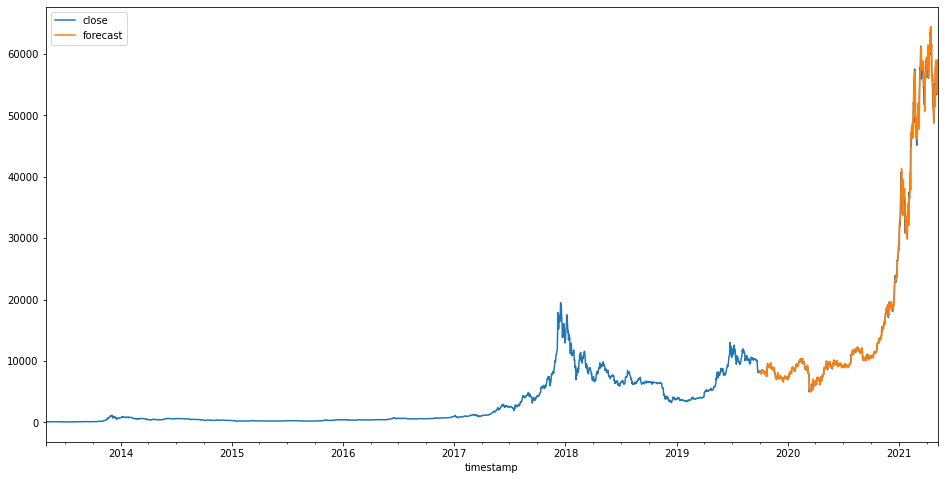

In [ ]:
model=sm.tsa.statespace.SARIMAX(data['close'],order=(2, 1, 0),seasonal_order=(2,1,0,12))
results=model.fit()

data['forecast']=results.predict(start=2346,end=2932,dynamic=False)
data[['close','forecast']].plot(figsize=(16,8))

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(data.forecast[2346:2933].values, test_val)

{'corr': 0.9960290650086369,
 'mae': 814.693745464962,
 'mape': 0.03920674517401873,
 'me': -84.1545116639162,
 'minmax': 0.03761660066105421,
 'mpe': -0.0030987332382257414,
 'rmse': 1516.9436780438798}

In [ ]:
model_month_sarima = auto_arima(df_month['close'], start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model_month_sarima.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1588.545, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1598.505, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1550.799, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1553.392, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1561.415, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1550.113, Time=0.90 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1592.231, Time=0.70 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1551.751, Time=1.21 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1551.792, Time=1.19 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1560.098, Time=0.85 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1552.244, Time=2.64 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=1551.347, Time=1.09 sec

Best model:  ARIMA(1,1,0)(2,

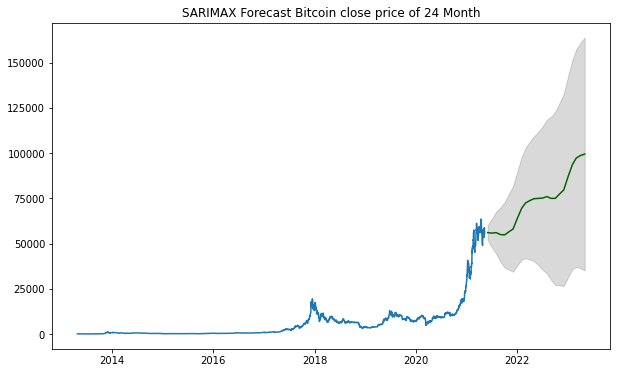

In [ ]:
# Forecast
n_periods = 24
fitted, confint = model_month_sarima.predict(n_periods=n_periods, 
#                                   exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['close'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast Bitcoin close price of 24 Month")
plt.show()

In [ ]:
import datetime
numdays = 100
date_list = [data.index[-1] + datetime.timedelta(days=x) for x in range(numdays)]
date_list

[Timestamp('2021-05-10 00:00:00'),
 Timestamp('2021-05-11 00:00:00'),
 Timestamp('2021-05-12 00:00:00'),
 Timestamp('2021-05-13 00:00:00'),
 Timestamp('2021-05-14 00:00:00'),
 Timestamp('2021-05-15 00:00:00'),
 Timestamp('2021-05-16 00:00:00'),
 Timestamp('2021-05-17 00:00:00'),
 Timestamp('2021-05-18 00:00:00'),
 Timestamp('2021-05-19 00:00:00'),
 Timestamp('2021-05-20 00:00:00'),
 Timestamp('2021-05-21 00:00:00'),
 Timestamp('2021-05-22 00:00:00'),
 Timestamp('2021-05-23 00:00:00'),
 Timestamp('2021-05-24 00:00:00'),
 Timestamp('2021-05-25 00:00:00'),
 Timestamp('2021-05-26 00:00:00'),
 Timestamp('2021-05-27 00:00:00'),
 Timestamp('2021-05-28 00:00:00'),
 Timestamp('2021-05-29 00:00:00'),
 Timestamp('2021-05-30 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-01 00:00:00'),
 Timestamp('2021-06-02 00:00:00'),
 Timestamp('2021-06-03 00:00:00'),
 Timestamp('2021-06-04 00:00:00'),
 Timestamp('2021-06-05 00:00:00'),
 Timestamp('2021-06-06 00:00:00'),
 Timestamp('2021-06-

In [ ]:
ds=pd.DataFrame(index=date_list[1:],columns=data.columns)
ds

close Close First Difference Seasonal First Difference forecast
2021-05-11   NaN                    NaN                       NaN      NaN
2021-05-12   NaN                    NaN                       NaN      NaN
2021-05-13   NaN                    NaN                       NaN      NaN
2021-05-14   NaN                    NaN                       NaN      NaN
2021-05-15   NaN                    NaN                       NaN      NaN
...          ...                    ...                       ...      ...
2021-08-13   NaN                    NaN                       NaN      NaN
2021-08-14   NaN                    NaN                       NaN      NaN
2021-08-15   NaN                    NaN                       NaN      NaN
2021-08-16   NaN                    NaN                       NaN      NaN
2021-08-17   NaN                    NaN                       NaN      NaN

[99 rows x 4 columns]

In [ ]:
future_df=pd.concat([data,ds])
future_df

close  ...  forecast
2013-04-29  144.539993  ...       NaN
2013-04-30  139.000000  ...       NaN
2013-05-01  116.989998  ...       NaN
2013-05-02  105.209999  ...       NaN
2013-05-03   97.750000  ...       NaN
...                ...  ...       ...
2021-08-13         NaN  ...       NaN
2021-08-14         NaN  ...       NaN
2021-08-15         NaN  ...       NaN
2021-08-16         NaN  ...       NaN
2021-08-17         NaN  ...       NaN

[3033 rows x 4 columns]

In [ ]:
future_df['forecast'] = results.predict(start = 2932, end = 3032,dynamic = False)  
future_df.tail(100)

close  ...      forecast
2021-05-10  55859.797545  ...  58101.008646
2021-05-11           NaN  ...  55324.557397
2021-05-12           NaN  ...  55195.035541
2021-05-13           NaN  ...  54285.839806
2021-05-14           NaN  ...  54930.977538
...                  ...  ...           ...
2021-08-13           NaN  ...  48300.786850
2021-08-14           NaN  ...  46755.112451
2021-08-15           NaN  ...  45914.339258
2021-08-16           NaN  ...  46435.415487
2021-08-17           NaN  ...  45926.488005

[100 rows x 4 columns]

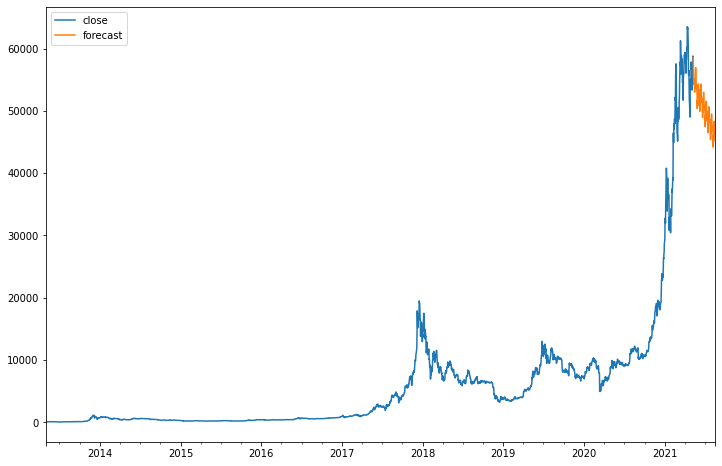

In [ ]:
future_df[['close', 'forecast']].plot(figsize=(12, 8))